## Imports

In [ ]:
# Imports

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_scheduler

import os
import random
from datetime import datetime
import time
from tqdm.auto import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


In [ ]:
# Проверяем, выполняется ли код в Google Colab
try:
    # Если мы можем импортировать google.colab, значит код запускается на Colab
    import glob
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    DEFAULT_PATH = os.path.join('/content', 'drive', 'MyDrive', 'Jupiter_notebook', 'Diplom')

except ImportError:
    # Если не получается импортировать, значит код запускается локально
    DEFAULT_PATH = os.getcwd()  # Используем текущую рабочую директорию

print(f"DEFAULT_PATH: {DEFAULT_PATH}")

Mounted at /content/drive
DEFAULT_PATH: /content/drive/MyDrive/Jupiter_notebook/Diplom


## Defaults

In [ ]:
# Устанавливаем путь к директории
# DEFAULT_PATH = os.getcwd()
DATASET_DIR = os.path.join(DEFAULT_PATH, 'datasets')
MODELS_PATH = os.path.join(DEFAULT_PATH, 'models')

# Пути к файлам
train_path = os.path.join(DATASET_DIR, 'train.csv')
val_path = os.path.join(DATASET_DIR, 'val.csv')
test_path = os.path.join(DATASET_DIR, 'test.csv')
final_dataset_path = os.path.join(DATASET_DIR, 'final_dataset.csv')

# Устанавливаем значение для random_state
RANDOM_STATE = 42

# Defaults for training
BATCH_SIZE = 16
NUM_EPOCHS = 10
LEARNING_RATE = 5e-4
EMBEDDING_DIM = 4
EPSILON = 1e-6


In [ ]:
# Select device "GPU" or "CPU"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
def set_seed(seed):
    np.random.seed(seed)                        # Устанавливаем сид для NumPy
    random.seed(seed)                           # Устанавливаем сид для стандартного модуля random
    torch.manual_seed(seed)                     # Устанавливаем сид для CPU
    if torch.cuda.is_available():               # Проверяем доступность GPU
        torch.cuda.manual_seed(seed)            # Устанавливаем сид для первого GPU
        torch.cuda.manual_seed_all(seed)        # Устанавливаем сид для всех GPU
    torch.backends.cudnn.deterministic = True   # Детерминированное поведение cuDNN
    torch.backends.cudnn.benchmark = False      # Отключаем оптимизацию для скорости

set_seed(RANDOM_STATE)

## Get Dataset

In [ ]:
if not all(os.path.exists(path) for path in [train_path, val_path, test_path]):
    # Читаем основной датасет
    df = pd.read_csv(final_dataset_path)

    # Разбиваем на train, val, test с сохранением пропорций
    train_df, temp = train_test_split(df, test_size=0.2, stratify=df['is_toxic'], random_state=RANDOM_STATE)
    val_df, test_df = train_test_split(temp, test_size=0.5, stratify=temp['is_toxic'], random_state=RANDOM_STATE)

    # Сохраняем в файлы
    train_df.to_csv(train_path, index=False)
    val_df.to_csv(val_path, index=False)
    test_df.to_csv(test_path, index=False)
else:
    # Загружаем существующие данные
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

## EDA

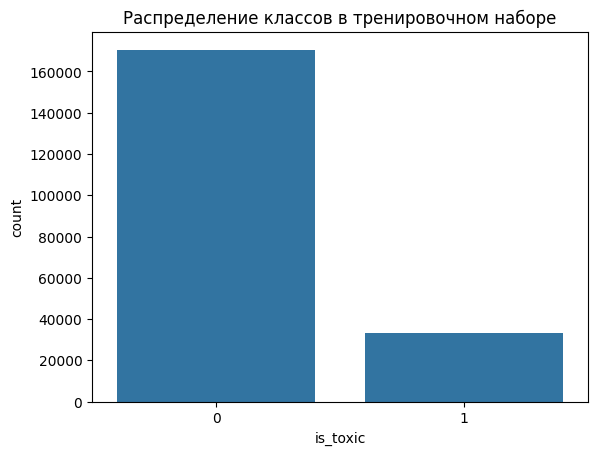

In [ ]:
# Посмотрим на распределение классов
sns.countplot(x='is_toxic', data=train_df)
plt.title('Распределение классов в тренировочном наборе')
plt.show()

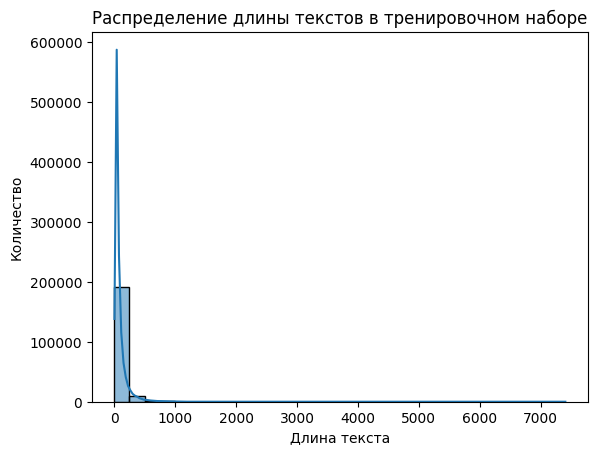

In [ ]:
# Длина текстов
train_df['text_length'] = train_df['text'].apply(len)
sns.histplot(train_df['text_length'], bins=30, kde=True)
plt.title('Распределение длины текстов в тренировочном наборе')
plt.xlabel('Длина текста')
plt.ylabel('Количество')
plt.show()

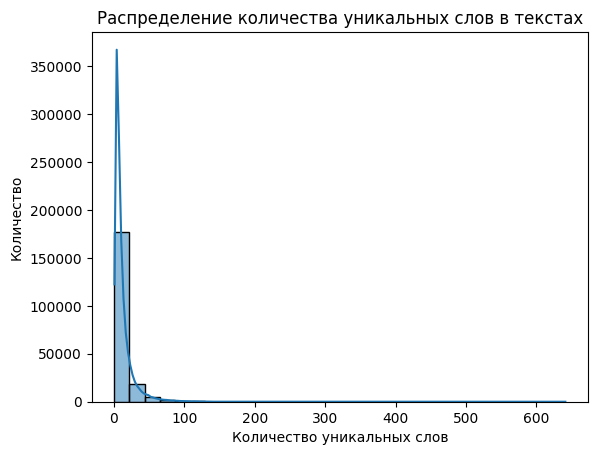

In [ ]:
# Посмотрим на количество уникальных слов в тексте
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(x.split())))
sns.histplot(train_df['unique_word_count'], bins=30, kde=True)
plt.title('Распределение количества уникальных слов в текстах')
plt.xlabel('Количество уникальных слов')
plt.ylabel('Количество')
plt.show()

In [ ]:
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx]['text']
        label = self.dataframe.iloc[idx]['is_toxic']
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
class TextClassificationTrainer:
    def __init__(self, model, optimizer, batch_size, num_epochs, learning_rate,
                 train_dataframe, val_dataframe, tokenizer, device='cpu',
                 models_dir='models', early_stopping=True, save_best_only=True, patience=3, model_name=''):

        self.train_dataset = TextDataset(train_dataframe, tokenizer)
        self.val_dataset = TextDataset(val_dataframe, tokenizer)

        self.model = model.to(device)
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=batch_size, shuffle=False)
        self.device = device
        self.loss_fn = nn.CrossEntropyLoss()
        self.tokenizer = tokenizer

        self.early_stopping = early_stopping
        self.save_best_only = save_best_only
        self.patience = patience

        self.models_dir = models_dir
        os.makedirs(self.models_dir, exist_ok=True)

        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.run_dir = os.path.join(self.models_dir, timestamp, model_name)
        os.makedirs(self.run_dir, exist_ok=True)

        self.scheduler = get_scheduler(
            name='linear',
            optimizer=self.optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_loader) * self.num_epochs
        )

    def train_and_evaluate(self, continue_training=False):
        results = []

        if continue_training:
            self.model = get_model(self.model, self.run_dir, self.device)

        best_val_loss = float('inf')
        patience_counter = 0

        print()

        for epoch in range(1, self.num_epochs + 1):
            start_time = time.time()

            train_loss, train_metrics = self.train_one_epoch(epoch)
            val_loss, val_metrics = self.evaluate(epoch)

            epoch_time = time.time() - start_time

            result = {
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch_time_sec': round(epoch_time, 2),
                **train_metrics,
                **val_metrics
            }
            results.append(result)
            self.save_results(results)

            if self.save_best_only:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    self.save_model(val_loss, val_metrics['val_f1_score'])
                else:
                    if self.early_stopping:
                        patience_counter += 1
                        if patience_counter >= self.patience:
                            print("Early stopping: no improvement")
                            break
            else:
                self.save_model(val_loss, val_metrics['val_f1_score'], epoch=epoch)

            print('-'*100)
            print(f"Epoch: {epoch}/{self.num_epochs:<8}"
                  f"Train Loss: {train_loss:<10.4f} "
                  f"Val Loss: {val_loss:<10.4f} "
                  f"Val Acc: {val_metrics['val_accuracy']:<10.4f} "
                  f"Val F1: {val_metrics['val_f1_score']:<10.4f} "
                  f"Time: {epoch_time:.2f}s")
            print('-'*100)

    def train_one_epoch(self, epoch):
        self.model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        for batch in tqdm(self.train_loader, desc=f"Training epoch {epoch}", colour='green'):
            inputs = batch['input_ids'].to(self.device)
            masks = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids=inputs, attention_mask=masks).logits
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_metrics = self.compute_metrics(all_labels, all_preds, prefix='train_')
        return total_loss / len(self.train_loader), train_metrics

    def evaluate(self, epoch):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc=f"Validation epoch {epoch}", colour='red'):
                inputs = batch['input_ids'].to(self.device)
                masks = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                outputs = self.model(input_ids=inputs, attention_mask=masks).logits
                loss = self.loss_fn(outputs, labels)
                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_metrics = self.compute_metrics(all_labels, all_preds, prefix='val_')
        return total_loss / len(self.val_loader), val_metrics

    def compute_metrics(self, labels, preds, prefix=''):
        accuracy = accuracy_score(labels, preds)
        f1 = f1_score(labels, preds, average='weighted', zero_division=1)
        precision = precision_score(labels, preds, average='weighted', zero_division=1)
        recall = recall_score(labels, preds, average='weighted', zero_division=1)
        return {
            f'{prefix}accuracy': accuracy,
            f'{prefix}f1_score': f1,
            f'{prefix}precision': precision,
            f'{prefix}recall': recall
        }

    def save_results(self, results):
        df = pd.DataFrame(results)
        self.results_df = df
        results_path = os.path.join(self.run_dir, 'training_results.csv')
        df.to_csv(results_path, index=False)

    def save_model(self, val_loss, val_f1, epoch=None):
        if self.save_best_only:
            model_filename = 'best_model.pt'
        else:
            model_filename = f'model_epoch_{epoch}_loss_{val_loss:.4f}_f1_{val_f1:.4f}.pt'

        model_path = os.path.join(self.run_dir, model_filename)
        torch.save(self.model.state_dict(), model_path)

    def predict_text(self, text, probability=False):
        self.model.eval()
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

        # Убираем token_type_ids, если он есть
        inputs = {k: v.to(self.device) for k, v in inputs.items() if k != "token_type_ids"}

        with torch.no_grad():
            outputs = self.model(**inputs).logits
            probs = torch.softmax(outputs, dim=1)
            pred = torch.argmax(probs, dim=1).item()
            if probability:
                return pred, probs[0][1].item()
            else:
                return pred

    def predict_batch(self, texts, probability=False):
        self.model.eval()
        results = []
        for text in texts:
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
            inputs = {k: v.to(self.device) for k, v in inputs.items() if k != "token_type_ids"}

            with torch.no_grad():
                outputs = self.model(**inputs).logits
                probs = torch.softmax(outputs, dim=1)
                pred = torch.argmax(probs, dim=1).item()
                if probability:
                    results.append((pred, probs[0][1].item()))
                else:
                    results.append(pred)
        return results


In [ ]:
def get_model(model, model_dir, device='cpu', model_filename='best_model.pt'):
    model_path = os.path.join(model_dir, model_filename)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    return model


def plot_training_curves(results_path, metric='accuracy'):
    df = pd.read_csv(results_path)
    epochs = df['epoch']

    plt.figure(figsize=(12, 5))

    # --- График 1: LOSS ---
    plt.subplot(1, 2, 1)
    if 'train_loss' in df.columns:
        plt.plot(epochs, df['train_loss'], label='Train Loss')
    if 'val_loss' in df.columns:
        plt.plot(epochs, df['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.grid(True)

    # --- График 2: Выбранная метрика ---
    plt.subplot(1, 2, 2)
    train_metric = f'train_{metric}'
    val_metric = f'val_{metric}'

    if train_metric in df.columns:
        plt.plot(epochs, df[train_metric], label='Train')
    if val_metric in df.columns:
        plt.plot(epochs, df[val_metric], label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel(metric.replace('_', ' ').capitalize())
    plt.title(f'{metric.replace("_", " ").capitalize()} Curve')
    plt.ylim(0.5, 1)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



## DeepPavlov/rubert-base-cased

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.optim import AdamW
model_name = 'DeepPavlov/rubert-base-cased'

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

optimizer = AdamW(model.parameters(), lr=2e-5)

trainer = TextClassificationTrainer(
    model=model,
    optimizer=optimizer,
    batch_size=384,
    num_epochs=50,
    learning_rate=2e-5,
    train_dataframe=train_df,
    val_dataframe=val_df,
    tokenizer=tokenizer,
    device=DEVICE,
    models_dir=MODELS_PATH,
    model_name='DeepPavlov_ruBert_base'
)
trainer.train_and_evaluate()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation epoch 1: 100%|██████████| 67/67 [00:43<00:00,  1.55it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1/50      Train Loss: 0.1112     Val Loss: 0.0671     Val Acc: 0.9760     Val F1: 0.9759     Time: 935.55s
----------------------------------------------------------------------------------------------------


Validation epoch 2: 100%|██████████| 67/67 [00:43<00:00,  1.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2/50      Train Loss: 0.0547     Val Loss: 0.0669     Val Acc: 0.9766     Val F1: 0.9766     Time: 937.42s
----------------------------------------------------------------------------------------------------


Validation epoch 3: 100%|██████████| 67/67 [00:43<00:00,  1.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3/50      Train Loss: 0.0376     Val Loss: 0.0796     Val Acc: 0.9747     Val F1: 0.9749     Time: 937.27s
----------------------------------------------------------------------------------------------------


Validation epoch 4: 100%|██████████| 67/67 [00:43<00:00,  1.54it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4/50      Train Loss: 0.0251     Val Loss: 0.0888     Val Acc: 0.9698     Val F1: 0.9704     Time: 937.60s
----------------------------------------------------------------------------------------------------


Validation epoch 5: 100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5/50      Train Loss: 0.0164     Val Loss: 0.0976     Val Acc: 0.9761     Val F1: 0.9761     Time: 936.89s
----------------------------------------------------------------------------------------------------


Validation epoch 6: 100%|██████████| 67/67 [00:43<00:00,  1.54it/s]

Early stopping: no improvement


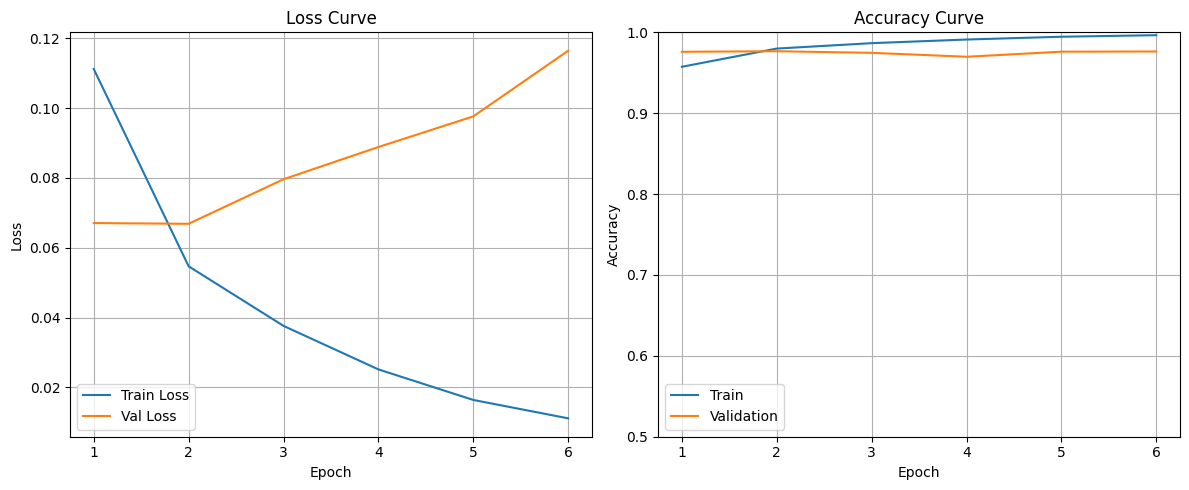

In [ ]:
results_path = os.path.join(trainer.run_dir, 'training_results.csv')
plot_training_curves(results_path)

In [ ]:
val_ds = TextDataset(test_df, tokenizer)

for _ in range(10):
    i = random.randint(0, len(val_ds) - 1)
    item = val_ds[i]
    text = tokenizer.decode(item['input_ids'].tolist(), skip_special_tokens=True)
    label = item['labels'].item()
    pred = trainer.predict_text(text)
    print(f"Text: {text}\nTrue: {label}, Pred: {pred}\n{'-'*60}")

Text: а с кошкой? с кошкой будет в порядке?!!!
True: 0, Pred: 0
------------------------------------------------------------
Text: что ты можешь сделать уебок если видео даже слепить не можешь
True: 1, Pred: 1
------------------------------------------------------------
Text: хороший состав был.
True: 0, Pred: 0
------------------------------------------------------------
Text: спасибо всем, кошечка нашлась.
True: 0, Pred: 0
------------------------------------------------------------
Text: да не будет их походу, нам сегодня : (
True: 0, Pred: 0
------------------------------------------------------------
Text: Хули меня искать, я и не скрываюсь, петуч, готов отстоять честь своего поросенка, пустозвон ёбаный?
True: 1, Pred: 1
------------------------------------------------------------
Text: К сожалению, это то немногое, за что их можно похвалить. Когда играл не отпускало ощущение дешевизны. И, вроде бы, и не то чтобы плохо, а всё же без души сделано.
True: 0, Pred: 0
-----------------

## sberbank-ai/ruBert-base

In [ ]:
model_name = 'sberbank-ai/ruBert-base'

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

optimizer = AdamW(model.parameters(), lr=2e-5)

trainer = TextClassificationTrainer(
    model=model,
    optimizer=optimizer,
    batch_size=384,
    num_epochs=50,
    learning_rate=2e-5,
    train_dataframe=train_df,
    val_dataframe=val_df,
    tokenizer=tokenizer,
    device=DEVICE,
    models_dir=MODELS_PATH,
    model_name='sberbank_ai_ruBert_base'
)
trainer.train_and_evaluate()

config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

Validation epoch 1: 100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1/50      Train Loss: 0.0954     Val Loss: 0.0700     Val Acc: 0.9763     Val F1: 0.9762     Time: 941.13s
----------------------------------------------------------------------------------------------------


Validation epoch 2: 100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2/50      Train Loss: 0.0566     Val Loss: 0.0714     Val Acc: 0.9772     Val F1: 0.9770     Time: 941.81s
----------------------------------------------------------------------------------------------------


Validation epoch 3: 100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3/50      Train Loss: 0.0374     Val Loss: 0.0762     Val Acc: 0.9755     Val F1: 0.9755     Time: 941.23s
----------------------------------------------------------------------------------------------------


Validation epoch 4: 100%|██████████| 67/67 [00:43<00:00,  1.53it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4/50      Train Loss: 0.0209     Val Loss: 0.0945     Val Acc: 0.9739     Val F1: 0.9739     Time: 941.30s
----------------------------------------------------------------------------------------------------


Validation epoch 5: 100%|██████████| 67/67 [00:43<00:00,  1.53it/s]

Early stopping: no improvement


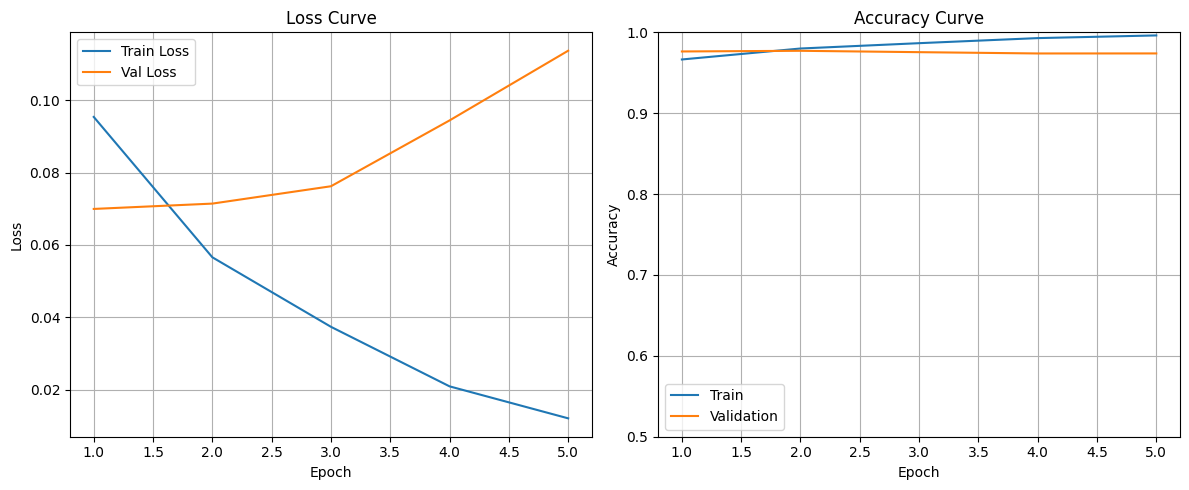

In [ ]:
results_path = os.path.join(trainer.run_dir, 'training_results.csv')
plot_training_curves(results_path)

In [ ]:
val_ds = TextDataset(test_df, tokenizer)

for _ in range(10):
    i = random.randint(0, len(val_ds) - 1)
    item = val_ds[i]
    text = tokenizer.decode(item['input_ids'].tolist(), skip_special_tokens=True)
    label = item['labels'].item()
    pred = trainer.predict_text(text)
    print(f"Text: {text}\nTrue: {label}, Pred: {pred}\n{'-'*60}")

## cointegrated/rubert-tiny2

In [ ]:
model_name = "cointegrated/rubert-tiny2"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

optimizer = AdamW(model.parameters(), lr=2e-5)

trainer = TextClassificationTrainer(
    model=model,
    optimizer=optimizer,
    batch_size=2048,
    num_epochs=50,
    learning_rate=2e-5,
    train_dataframe=train_df,
    val_dataframe=val_df,
    tokenizer=tokenizer,
    device=DEVICE,
    models_dir=MODELS_PATH,
    patience=5,
    model_name='cointegrated_rubert_tiny2'
)
trainer.train_and_evaluate()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Validation epoch 1: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


----------------------------------------------------------------------------------------------------
Epoch: 1/50      Train Loss: 0.2148     Val Loss: 0.1019     Val Acc: 0.9632     Val F1: 0.9629     Time: 282.44s
----------------------------------------------------------------------------------------------------


Validation epoch 2: 100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


----------------------------------------------------------------------------------------------------
Epoch: 2/50      Train Loss: 0.0934     Val Loss: 0.0861     Val Acc: 0.9693     Val F1: 0.9691     Time: 289.93s
----------------------------------------------------------------------------------------------------


Validation epoch 3: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


----------------------------------------------------------------------------------------------------
Epoch: 3/50      Train Loss: 0.0765     Val Loss: 0.0797     Val Acc: 0.9716     Val F1: 0.9714     Time: 289.14s
----------------------------------------------------------------------------------------------------


Validation epoch 4: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


----------------------------------------------------------------------------------------------------
Epoch: 4/50      Train Loss: 0.0659     Val Loss: 0.0776     Val Acc: 0.9726     Val F1: 0.9724     Time: 289.11s
----------------------------------------------------------------------------------------------------


Validation epoch 5: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


----------------------------------------------------------------------------------------------------
Epoch: 5/50      Train Loss: 0.0578     Val Loss: 0.0839     Val Acc: 0.9694     Val F1: 0.9697     Time: 287.17s
----------------------------------------------------------------------------------------------------


Validation epoch 6: 100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


----------------------------------------------------------------------------------------------------
Epoch: 6/50      Train Loss: 0.0512     Val Loss: 0.0796     Val Acc: 0.9712     Val F1: 0.9714     Time: 285.90s
----------------------------------------------------------------------------------------------------


Validation epoch 7: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


----------------------------------------------------------------------------------------------------
Epoch: 7/50      Train Loss: 0.0453     Val Loss: 0.0789     Val Acc: 0.9724     Val F1: 0.9725     Time: 285.62s
----------------------------------------------------------------------------------------------------


Validation epoch 8: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]


----------------------------------------------------------------------------------------------------
Epoch: 8/50      Train Loss: 0.0393     Val Loss: 0.0821     Val Acc: 0.9727     Val F1: 0.9728     Time: 285.19s
----------------------------------------------------------------------------------------------------


Validation epoch 9: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]


----------------------------------------------------------------------------------------------------
Epoch: 9/50      Train Loss: 0.0348     Val Loss: 0.0859     Val Acc: 0.9736     Val F1: 0.9736     Time: 286.17s
----------------------------------------------------------------------------------------------------


Validation epoch 10: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]

Early stopping: no improvement


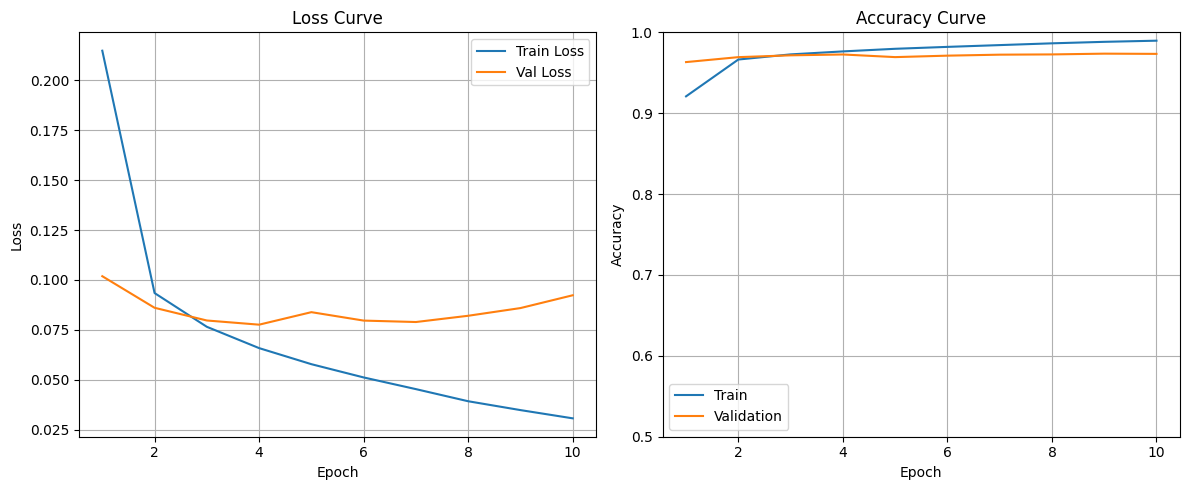

In [ ]:
results_path = os.path.join(trainer.run_dir, 'training_results.csv')
plot_training_curves(results_path)

In [ ]:
val_ds = TextDataset(test_df, tokenizer)

for _ in range(5):
    i = random.randint(0, len(val_ds) - 1)
    item = val_ds[i]
    text = tokenizer.decode(item['input_ids'].tolist(), skip_special_tokens=True)
    label = item['labels'].item()
    pred = trainer.predict_text(text)
    print(f"Text: {text}\nTrue: {label}, Pred: {pred}\n{'-'*60}")


Text: а с кошкой? с кошкой будет в порядке?!!!
True: 0, Pred: 0
------------------------------------------------------------
Text: что ты можешь сделать уебок если видео даже слепить не можешь
True: 1, Pred: 1
------------------------------------------------------------
Text: хороший состав был.
True: 0, Pred: 0
------------------------------------------------------------
Text: спасибо всем, кошечка нашлась.
True: 0, Pred: 0
------------------------------------------------------------
Text: да не будет их походу, нам сегодня : (
True: 0, Pred: 0
------------------------------------------------------------
